Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения.

**Задание 1**

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [2]:
# импортируем необходимые библиотеки для работы с данными

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pingouin as pg 
OUTDATED_IGNORE=1

Для начала загрузим данные и проведем разведочный анализ.

In [3]:
# создаем датафрейм с данными о времени регистрации пользователей

reg_data = pd.read_csv ('../shared/problem1-reg_data.csv', sep = ';') 

In [4]:
reg_data. head (5) # проверяем корректность отображения данных

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
reg_data.shape # смотрим размер датафрейма

(1000000, 2)

In [6]:
# проверяем отсутствие ошибки повторной регистрации через совпадение количества уникальных пользователей с размером датафрейма

reg_data.uid.nunique () == reg_data.shape [0]

True

In [7]:
reg_data.dtypes # смотрим типы данных в колонках

reg_ts    int64
uid       int64
dtype: object

In [8]:
reg_data. isna (). sum () # проверяем количество пропущенных значений

reg_ts    0
uid       0
dtype: int64

In [9]:
 # создаем датафрейм с данными о времени захода пользователей в игру
    
auth_data = pd.read_csv ('../shared/problem1-auth_data.csv', sep = ';')

In [10]:
auth_data. head (5) # проверяем корректность отображения данных

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [11]:
auth_data.shape # смотрим размер датафрейма

(9601013, 2)

In [12]:
# проверяем корректность логирования входа в игру (только зарегистрированные пользователи могут играть)

auth_data.uid.nunique () == reg_data.uid.nunique ()

True

In [13]:
auth_data.dtypes # смотрим типы данных в колонках

auth_ts    int64
uid        int64
dtype: object

In [14]:
auth_data. isna (). sum () # проверяем количество пропущенных значений

auth_ts    0
uid        0
dtype: int64

In [15]:
# в среднем на каждую регистрацию мы получаем 9.6 заходов в игру

round (auth_data.shape [0] / reg_data.shape [0], 1)

9.6

Как мы видим, данные загрузились корректно, пропущенные значения отстутствуют. В обоих датафремах присутствует колонка uid - уникальный идентификатор пользователей и колока со временем регистрации в формате Unix timestamp. В датафреме с заходами пользователей в игру больше данных, чем в датафрейме с регистрацией и мы вычислили, что в среднем на каждую регистрацию приходится 9.6 заходов в игру. 

Закончив с разведочным анализом, перейдем к трансформации датафреймов. Для начала нужно перевести колонки со временем в формат datetime. Расчитывать retention мы будем по дням, поэтому часы, минуты и секунды нам не понадобятся.

In [16]:
reg_data.reg_ts = pd.to_datetime (reg_data.reg_ts, unit = 's') # переводим таймстепм в формат datetime

reg_data.reg_ts = reg_data.reg_ts.map (lambda x: x.strftime('%Y-%m-%d')) # преобразуем datetime в строку и обрезаем часы, минуты и секунды

reg_data.reg_ts = pd.to_datetime (reg_data.reg_ts) # переводим строку с преобразованной датой обратно в формат datetime

In [17]:
# проводим те же преобразования с другим датафреймом

auth_data.auth_ts = pd.to_datetime (auth_data.auth_ts, unit = 's')
auth_data.auth_ts = auth_data.auth_ts.map (lambda x: x.strftime('%Y-%m-%d'))
auth_data.auth_ts = pd.to_datetime (auth_data.auth_ts)

In [18]:
# объединяем датафреймы по общей колонке и записываем результат в новый датафрейм

df = reg_data.merge (auth_data, on = 'uid')

In [19]:
df.head (5) # проверяем корректность отображения данных

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [20]:
df.shape # смотрим размер датафрейма

(9601013, 3)

In [21]:
df.loc[df.duplicated()] # проверяем наличие дубликатов

,reg_ts,uid,auth_ts


In [22]:
[df.reg_ts.min (), df.reg_ts.max ()] # смотрим диапазон дат регистрации пользователей в датафрейме

[Timestamp('1998-11-18 00:00:00'), Timestamp('2020-09-23 00:00:00')]

В результате объединения исходных датафреймов мы получили новый, где каждому уникальному пользователю сопоставляется дата регистрации и даты всех его заходов в игру. При этом в новом датафрейме нет дубликатов, что может свидетельствовать о том, что данные логируются верно и для каждого уникального пользователя один раз за день фиксируются данные о его аутентификации в приложении. Это предоставляет нам возможность создать колонку с разницой дней между датами входа и датой регистрации для каждой даты регистрации и уникального пользователя. Эта колонка пригодится нам для расчета retention.

In [23]:
df ['n_days'] = df.auth_ts - df.reg_ts # создаем колонку с разницей дней

Теперь нам нужно предоставить возможность менеджеру самому выбирать по каким дням он хочет посмотреть когорты пользователей и до какого дня удержания. Для этого создадим две переменных, в которые можно будет вручную вносить нужные значения в виде списка.

Мы заполним ради примера эти переменные произвольными значениями.

In [29]:
# создаем переменную cohorts, в которую можно вносить интересующие дни регистрации пользователей
# создаем переменную days, в которую можно вносить интересующие дни удержания пользователей

cohorts = ['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05']
days = ['0 days', '1 days', '2 days', '3 days', '4 days', '5 days', '6 days', '7 days']

In [30]:
# отбираем нужные нам данные в общем датафрейме и записываем их в новый датафрейм

data = df.query ('reg_ts == @cohorts & n_days == @days')

In [31]:
data.head()

,reg_ts,uid,auth_ts,n_days
9545203,2020-09-01,1070035,2020-09-01,0 days
9545204,2020-09-01,1070035,2020-09-02,1 days
9545209,2020-09-01,1070036,2020-09-01,0 days
9545210,2020-09-01,1070037,2020-09-01,0 days
9545211,2020-09-01,1070038,2020-09-01,0 days


Далее посчитаем для каждой когорты пользователей по дате регистрации количество их заходов в игру для каждого n-ного дня и запишем результат в новый датафрейм.

In [32]:
# группируем датафрейм по дате регистрации и номеру дня, считаем количество уникальных пользователей,
# переименовываем колонку с ними и записываем результат в новый датафрейм

df_ret = data. groupby (['reg_ts', 'n_days'], as_index = False) \
            .agg ({'uid': 'nunique'}). rename (columns = {'uid': 'n_users'})

In [33]:
df_ret.head()

,reg_ts,n_days,n_users
0,2020-09-01,0 days,1586
1,2020-09-01,1 days,32
2,2020-09-01,2 days,65
3,2020-09-01,3 days,67
4,2020-09-01,4 days,73


Day N Retention рассчитывается как процент пользователей, которые пришли в приложение спустя n дней после регистрации. Для его расчета нам нужно сначала создать колонку с количеством пользователей, зашедших в приложение в день регистрации для каждой даты регистрации.

In [34]:
# фильтруем предудыщий датафрейм по нужному значению, убираем лишнюю колонку и переименовываем другую колонку

df_0_ret = df_ret. query ('n_days == "0 days"') \
                .drop (columns = 'n_days'). rename (columns = {'n_users': 'n_users_zero'})

In [35]:
df_0_ret.head()

,reg_ts,n_users_zero
0,2020-09-01,1586
8,2020-09-02,1588
16,2020-09-03,1591
24,2020-09-04,1593
32,2020-09-05,1596


In [36]:
pd.options.mode.chained_assignment = None # отключаем прежупреждения, поскольку мы внимательно следим за всеми изменениями

Теперь объединим эти датафреймы по дате регистрации в общий датафрейм для расчета retention

In [38]:
df_reten = df_ret. merge (df_0_ret, on = 'reg_ts')

In [39]:
df_reten.head()

,reg_ts,n_days,n_users,n_users_zero
0,2020-09-01,0 days,1586,1586
1,2020-09-01,1 days,32,1586
2,2020-09-01,2 days,65,1586
3,2020-09-01,3 days,67,1586
4,2020-09-01,4 days,73,1586


Далее следует избавиться от колонок с нулевым днем, так как они не дадут нам никакой ценной информации при расчете удержания (поскольку нулевой день - это день регистрации и удержание в нем всегда будет 100%)

In [40]:
# оставляем значения ненулевых дней и записываем в новый датафрейм

df_reten = df_reten. query ('n_days != "0 days"')

In [41]:
# делим количество пользователей в n-ный день на количество пользователей в день регистрации и записываем результат в новую колонку

df_reten ['retention'] = df_reten.n_users / df_reten.n_users_zero

In [42]:
# приводим данные в нужный формат для адекватного отображения на графике

df_reten.n_days = df_reten.n_days.astype ('str')
df_reten.reg_ts = df_reten.reg_ts.astype ('str')

In [43]:
df_reten.head()

,reg_ts,n_days,n_users,n_users_zero,retention
1,2020-09-01,1 days,32,1586,0.020177
2,2020-09-01,2 days,65,1586,0.040984
3,2020-09-01,3 days,67,1586,0.042245
4,2020-09-01,4 days,73,1586,0.046028
5,2020-09-01,5 days,102,1586,0.064313


Теперь нам нужно избавиться от лишних колонок и преобразовать датафрейм в таблицу для построения heatmap

In [44]:
# избавляемся от лишних колонок

df_reten = df_reten.drop (columns = ['n_users', 'n_users_zero'])

In [45]:
# преобразуем датафрейм и записываем результат в новую переменную

df_retention = df_reten.pivot (index = 'reg_ts', columns = 'n_days', values = 'retention')

In [46]:
df_retention

n_days,1 days,2 days,3 days,4 days,5 days,6 days,7 days
reg_ts,,,,,,,
2020-09-01,0.020177,0.040984,0.042245,0.046028,0.064313,0.056116,0.064313
2020-09-02,0.025189,0.039043,0.046599,0.056675,0.062343,0.071159,0.062972
2020-09-03,0.023256,0.054054,0.047140,0.065368,0.069767,0.085481,0.063482
2020-09-04,0.020088,0.036409,0.036409,0.051475,0.064030,0.072819,0.049592
2020-09-05,0.027569,0.039474,0.046366,0.054511,0.058897,0.074561,0.048872


Теперь можно строить график

Text(0.5, 24.0, 'Дней после регистрации')

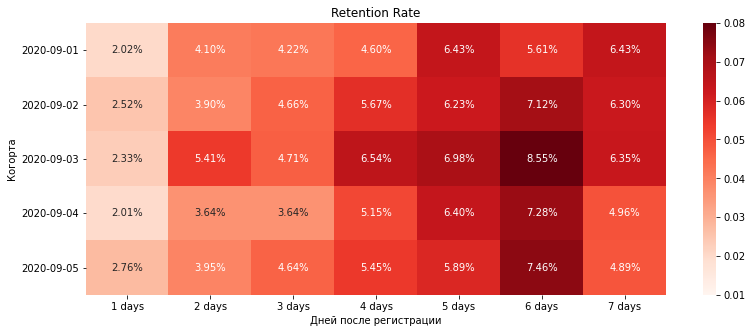

In [47]:
fig, ax = plt.subplots(figsize=(13, 5))
sns.heatmap (df_retention, annot=True, fmt='.2%', cmap = 'Reds', vmin=0.01, vmax=0.08)

plt.title('Retention Rate')
plt.ylabel('Когорта')
plt.xlabel('Дней после регистрации')

Теперь упакуем наш алгоритм расчета retention и построения соответствующего графика в тело питоновской функции

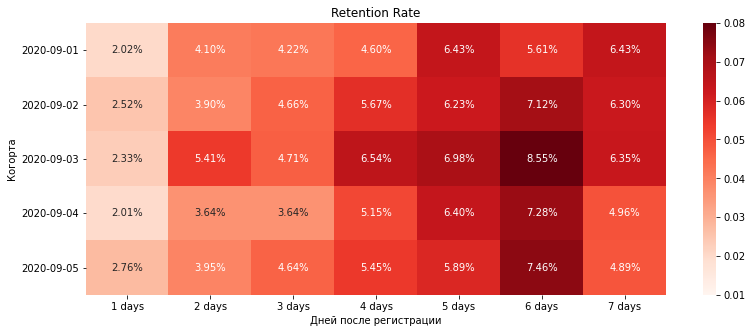

In [48]:
def retention (reg_data, auth_data):
    
    reg_data.reg_ts = pd.to_datetime (reg_data.reg_ts, unit = 's')
    reg_data.reg_ts = reg_data.reg_ts.map (lambda x: x.strftime('%Y-%m-%d'))
    reg_data.reg_ts = pd.to_datetime (reg_data.reg_ts)
    
    auth_data.auth_ts = pd.to_datetime (auth_data.auth_ts, unit = 's')
    auth_data.auth_ts = auth_data.auth_ts.map (lambda x: x.strftime('%Y-%m-%d'))
    auth_data.auth_ts = pd.to_datetime (auth_data.auth_ts)
    
    df = reg_data.merge (auth_data, on = 'uid')
    df ['n_days'] = df.auth_ts - df.reg_ts
    
    # в переменной cohorts нужно перечислить через запятую интересующие даты регистрации пользователей в формате 'YYMMDD'
    cohorts = ['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05'] 
    
    # в переменной days нужно перечислить через запятую интересующие дни удержания пользователей в формате 'n days'
    days = ['0 days', '1 days', '2 days', '3 days', '4 days', '5 days', '6 days', '7 days']
    
    data = df.query ('reg_ts == @cohorts & n_days == @days')
    
    df_ret = data. groupby (['reg_ts', 'n_days'], as_index = False). agg ({'uid': 'nunique'}) \
                .rename (columns = {'uid': 'n_users'})
    df_0_ret = df_ret. query ('n_days == "0 days"'). drop (columns = 'n_days') \
                    .rename (columns = {'n_users': 'n_users_zero'})
    
    df_reten = df_ret. merge (df_0_ret, on = 'reg_ts')
    df_reten = df_reten. query ('n_days != "0 days"')
    df_reten ['retention'] = df_reten.n_users / df_reten.n_users_zero
    
    df_reten.n_days = df_reten.n_days.astype ('str')
    df_reten.reg_ts = df_reten.reg_ts.astype ('str')
    df_reten = df_reten.drop (columns = ['n_users', 'n_users_zero'])
    
    df_retention = df_reten.pivot (index = 'reg_ts', columns = 'n_days', values = 'retention')
    
   
    fig, ax = plt.subplots(figsize=(13, 5)) # в скобках можно изменить высоту и ширину графика для лучшего отображения
    sns.heatmap (df_retention, annot=True, fmt='.2%', cmap = 'Reds', vmin=0.01, vmax=0.08)
    plt.title('Retention Rate')
    plt.ylabel('Когорта')
    plt.xlabel('Дней после регистрации')
    
pd.options.mode.chained_assignment = None
retention (reg_data, auth_data)

В дополнение к основной функции расчета retention, мы можем создать дополнительную функцию, которая будет считать усредненный retention для когорот последнего месяца по его дням. Наш новый алгоритм расчета в основном будет повторять предыдущий с некоторыми модификациями.

Давайте отберем данные за последний месяц и на их основе рассчитаем retention n-ного дня.

In [49]:
delta_month = df.reg_ts - pd.Timedelta (days=31) # создаем серию дат со смещением на месяц назад

In [50]:
delta_month = delta_month.max () # отбираем из серии смещенных на месяц назад дат самую последнюю

In [51]:
data_month = df [df.reg_ts >= delta_month] # отбираем данные за последний месяц и записываем их в новый датафрейм

In [52]:
data_month.head (5) # проверяем корректность отображения данных

,reg_ts,uid,auth_ts,n_days
9514492,2020-08-23,1054372,2020-08-23,0 days
9514493,2020-08-23,1054373,2020-08-23,0 days
9514494,2020-08-23,1054374,2020-08-23,0 days
9514495,2020-08-23,1054374,2020-08-24,1 days
9514496,2020-08-23,1054374,2020-08-27,4 days


In [60]:
data_month.shape # смотрим размер датафрейма

(86521, 4)

In [53]:
data_month ['n_days'] = data_month.auth_ts - data_month.reg_ts # создаем колонку с разницей дней регистрации и аутентификации

In [54]:
data_month.head (5)

,reg_ts,uid,auth_ts,n_days
9514492,2020-08-23,1054372,2020-08-23,0 days
9514493,2020-08-23,1054373,2020-08-23,0 days
9514494,2020-08-23,1054374,2020-08-23,0 days
9514495,2020-08-23,1054374,2020-08-24,1 days
9514496,2020-08-23,1054374,2020-08-27,4 days


Далее посчитаем для каждой когорты пользователей по дате регистрации количество их заходов в игру для каждого n-ного дня и запишем результат в новый датафрейм.

In [55]:
# группируем датафрейм по дате регистрации и номеру дня, считаем количество уникальных пользователей,
# переименовываем колонку с ними и записываем результат в новый датафрейм

df_ret_month = data_month. groupby (['reg_ts', 'n_days'], as_index = False) \
            .agg ({'uid': 'nunique'}). rename (columns = {'uid': 'n_users'})

In [56]:
df_ret_month.head (5)

,reg_ts,n_days,n_users
0,2020-08-23,0 days,1562
1,2020-08-23,1 days,39
2,2020-08-23,2 days,60
3,2020-08-23,3 days,76
4,2020-08-23,4 days,77


Day N Retention рассчитывается как процент пользователей, которые пришли в приложение спустя n дней после регистрации. Для его расчета нам нужно сначала создать колонку с количеством пользователей, зашедших в приложение в день регистрации для каждой даты регистрации.

In [57]:
# фильтруем предудыщий датафрейм по нужному значению, убираем лишнюю колонку и переименовываем другую колонку

df_0_ret_month = df_ret_month. query ('n_days == "0 days"') \
                .drop (columns = 'n_days'). rename (columns = {'n_users': 'n_users_zero'})

In [58]:
df_0_ret_month. head (5)

,reg_ts,n_users_zero
0,2020-08-23,1562
32,2020-08-24,1565
63,2020-08-25,1567
93,2020-08-26,1570
122,2020-08-27,1573


Далее объединим эти датафреймы по дате регистрации, разделим количество пользователей в n-ный день на количество пользователей в день регистрации и умножим результат на 100%. Таким образом, мы получим колонку с Day N Retention.

In [59]:
# объединяем датафреймы

df_reten_month = df_ret_month. merge (df_0_ret_month, on = 'reg_ts')

In [60]:
# оставляем значения ненулевых дней и записываем в новый датафрейм

df_reten_month = df_reten_month. query ('n_days != "0 days"')

In [61]:
# создаем колонку с retention

df_reten_month ['retention'] = ((df_reten_month.n_users / df_reten_month.n_users_zero ) * 100)

In [62]:
df_reten_month. head (5)

,reg_ts,n_days,n_users,n_users_zero,retention
1,2020-08-23,1 days,39,1562,2.496799
2,2020-08-23,2 days,60,1562,3.841229
3,2020-08-23,3 days,76,1562,4.865557
4,2020-08-23,4 days,77,1562,4.929577
5,2020-08-23,5 days,109,1562,6.978233


По сути, мы произвели анализ Day N Retention для каждой когорты пользователей по дням регистрации за последний месяц. 

Далее усредним retention n-ного дня по всем когортам за последний месяц и построим lineplot.

In [63]:
# Группируем предыдущий датафрейм по n-ному дню, рассчитываем для него средний retention с округлением до десятых 
# и записываем результат в новый датафрейм

df_retention_month = df_reten_month. groupby ('n_days', as_index = False). agg ({'retention': 'mean'})
df_retention_month.retention = round (df_retention_month.retention, 1)

In [64]:
# Переводим колонку с днями из формата timedelta в строчный формат, чтобы на графике отображались отдельные дни

df_retention_month.n_days = df_retention_month.n_days.astype ('str')

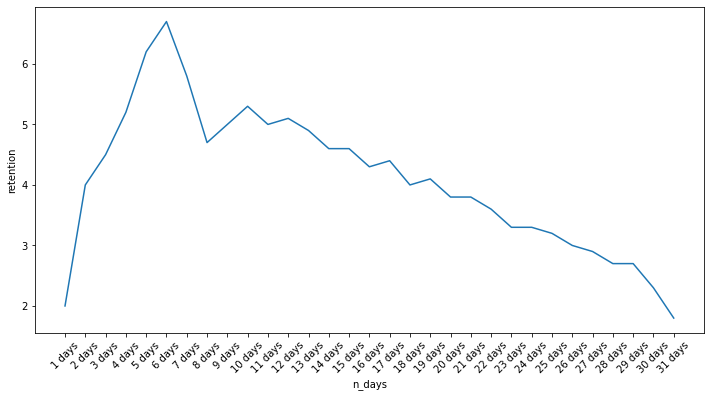

In [65]:
# Строим интерактивный график с метрикой удержания

plt.figure (figsize=(12, 6))
ax = sns.lineplot (data = df_retention_month, x = 'n_days', y = 'retention')
ax.tick_params(axis='x', rotation=45)
plt.show ()

Теперь упакуем наш алгоритм расчета среднего месячного retention и построения соответствующего графика в тело питоновской функции

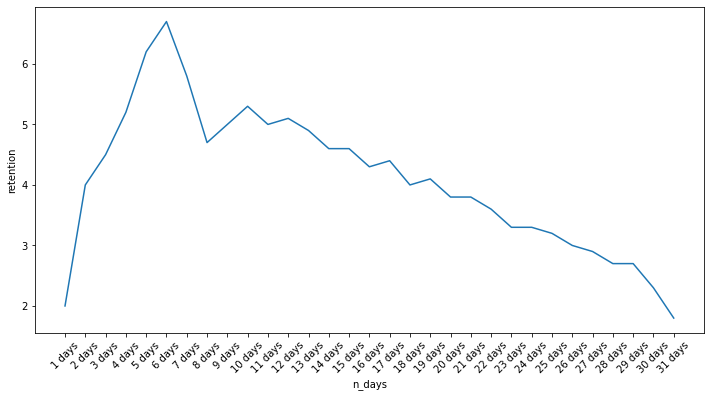

In [66]:
def retention_month (reg_data, auth_data):
    
    reg_data.reg_ts = pd.to_datetime (reg_data.reg_ts, unit = 's')
    reg_data.reg_ts = reg_data.reg_ts.map (lambda x: x.strftime('%Y-%m-%d'))
    reg_data.reg_ts = pd.to_datetime (reg_data.reg_ts)
    
    auth_data.auth_ts = pd.to_datetime (auth_data.auth_ts, unit = 's')
    auth_data.auth_ts = auth_data.auth_ts.map (lambda x: x.strftime('%Y-%m-%d'))
    auth_data.auth_ts = pd.to_datetime (auth_data.auth_ts)
    
    df = reg_data.merge (auth_data, on = 'uid')
    
    delta_month = df.reg_ts - pd.Timedelta (days=31)
    delta_month = delta_month.max ()
    data_month = df [df.reg_ts >= delta_month]
    
    data_month ['n_days'] = data_month.auth_ts - data_month.reg_ts
    df_ret_month = data_month. groupby (['reg_ts', 'n_days'], as_index = False). agg ({'uid': 'nunique'}) \
                .rename (columns = {'uid': 'n_users'})
    df_0_ret_month = df_ret_month. query ('n_days == "0 days"'). drop (columns = 'n_days') \
                    .rename (columns = {'n_users': 'n_users_zero'})
    
    df_reten_month = df_ret_month. merge (df_0_ret_month, on = 'reg_ts')
    df_reten_month = df_reten_month. query ('n_days != "0 days"')
    df_reten_month ['retention'] = ((df_reten_month.n_users / df_reten_month.n_users_zero ) * 100)
    
    df_retention_month = df_reten_month. groupby ('n_days', as_index = False). agg ({'retention': 'mean'})
    df_retention_month.retention = round (df_retention_month.retention, 1)
    df_retention_month.n_days = df_retention_month.n_days.astype ('str')
    
    plt.figure (figsize=(12, 6))
    ax = sns.lineplot (data = df_retention_month, x = 'n_days', y = 'retention')
    ax.tick_params(axis='x', rotation=45)
    ret_fig = plt.show ()
    return (ret_fig)

pd.options.mode.chained_assignment = None
retention_month (reg_data, auth_data)

--------------
**Задание 2**

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Для начала загрузим данные и проведем разведочный анализ.

In [67]:
df_1 = pd.read_csv ('../Final_project/Проект_1_Задание_2.csv', sep = ';')

In [68]:
df_1. head (5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [69]:
df_1.shape

(404770, 3)

In [70]:
df_1.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [71]:
df_1. isna (). sum ()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [72]:
# переименуем колонки для большей наглядности

testgroup_dict = {'a':'control', 'b':'test'}
df_1.testgroup = df_1.testgroup.map (testgroup_dict)

In [73]:
df_1. head (5)

,user_id,revenue,testgroup
0,1,0,test
1,2,0,control
2,3,0,control
3,4,0,test
4,5,0,test


Мы видим, что данные загрузились нормально, пропусков нет. У нас есть три колонки: первая отражает id пользователя, вторая - доход, который он принес и третья - его принадлежность к группе тестирования. Целью нашего А/Б-теста является увеличение дохода. Детектировать мы его будем с помощью целевых метрик: конверсии, ARPU и ARPPU.

Начнем с конверсии в покупку. Из условий задачи нам известно, что конверсия в покупку в контрольной и тестовой группах изменилась. Давайте проверим статзначимость этого изменения с помощью теста Хи-квадрат, а потом подсчитаем размер эффекта. 

Для реализации этого теста нам нужно создать таблицу сопряженности, состоящую из пересечения двух категориальных делений (тестовая/контрольная группа и совершение/несовершение покупки). Если деление на тестовую и контрольную группу в наших данных уже приведено, то доход у нас разделен не по факту его наличия/отсутствия, а в виде суммы денег. Следовательно, нам нужно написать функцию, которая переведет эти данные в нужный нам вид.

In [74]:
# определяем функцию, которая присваивает единицу, если пользователь совершил покупку и ноль, если нет
# создаём колонку датафрейма, реализующую эту функцию

def f(row):
 if row ['revenue'] == 0:
     val = 0
 else:
     val = 1
 return val

df_1 ['CR_coef'] = df_1.apply (f, axis = 1) 

df_1.head ()

,user_id,revenue,testgroup,CR_coef
0,1,0,test,0
1,2,0,control,0
2,3,0,control,0
3,4,0,test,0
4,5,0,test,0


In [75]:
# строим таблицу сопряженности и проверяем результат

df_cross = pd.crosstab (df_1.testgroup, df_1.CR_coef)
df_cross

CR_coef,0,1
testgroup,,
control,200175,1928
test,200862,1805


In [76]:
# проводим тест Хи-квадрат и выводим статистику и p-value

stat, p, dof, expected = scipy.stats.chi2_contingency(df_cross) 
stat, p

(4.374729521260405, 0.03647561892312613)

В качестве критического уровня значимости (или альфа-уровня значимости) мы берем конвенциональный стандарт - 0.05.

Как видно из теста, p-value меньше 0.05, что дает нам основания отвергнуть нулевую гипотезу и принять альтернативную о статзначимости различий в конверсии в покупку между тестовой и контрольной группой.

Теперь проверим как количественно изменилась конверсия в ходе эксперимента и в какую сторону (ухудшение/улучшение). 

Конверсию в покупку мы будем считать как отношение числа купивших к общему числу пользователей, умноженное на 100%. Мы не будем явно указывать проценты в наших вычислениях для их удобства, но будем помнить о них.

In [77]:
# считаем конверсию в контрольной группе

conv_control = (df_cross [1].control / (df_cross [1].control + df_cross [0].control)) * 100
conv_control

0.9539690157988748

In [78]:
# считаем конверсию в тестовой группе

conv_test = (df_cross [1].test / (df_cross [1].test + df_cross [0].test)) * 100
conv_test

0.8906235351586593

In [79]:
round (conv_test - conv_control, 2)

-0.06

Конверсия в тестовой группе упала на 6 сотых процента. Это небольшое падение, но мы можем рассчитать размер эффекта более формально для большей уверенности.

Так как у нас таблица 2х2, то можем воспользоваться φ-критерием.

In [80]:
φ = np.sqrt (stat / df_1.shape [0])
φ

0.003287543023146198

In [81]:
round (φ, 3)

0.003

У нас получился очень малый размер эффекта, но он все равно статистически значим.

Проверим теперь статистическую значимость и размер эффекта изменения ARPU - метрики среднего дохода с пользователя.

In [82]:
# создаем датафреймы с тестовой и контрольной группами

df_test = df_1.query ('testgroup == "test"')
df_control = df_1.query ('testgroup == "control"')

In [83]:
# проверяем размеры контрольной и тестовой групп

df_control.shape [0], df_test.shape [0]

(202103, 202667)

In [84]:
# создаем для удобства расчётов датафреймы с доходами тестовой и контрольной групп

df_test_u_rev = df_test.revenue
df_control_u_rev = df_control.revenue

Теперь проверим нормальность распределений дохода в контрольной и тестовой группе с помощью критерия Д'Агостино, который лежит под капотом scipy.stats.normaltest

In [85]:
# реализуем проверку распределений на нормальность

[scipy.stats.normaltest (df_control_u_rev), scipy.stats.normaltest (df_test_u_rev)]

[NormaltestResult(statistic=585152.7312728433, pvalue=0.0),
 NormaltestResult(statistic=326622.39540856465, pvalue=0.0)]

Тест на нормальность рассчитал для обоих распределений p-значение ниже критического уровня значимости 0.05, что позволяет нам отклонить нулевую гипотезу о нормальности распределений и принять альтернативную гипотезу о ненормальном характере распределений.

Давайте визуально оценим формы нашх распределений на графиках. Это поможет нам точнее понять их характер.

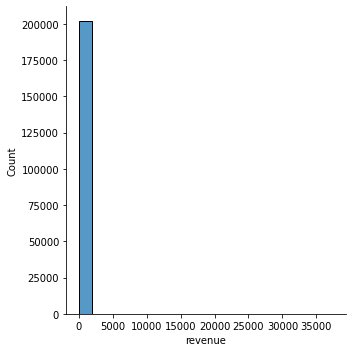

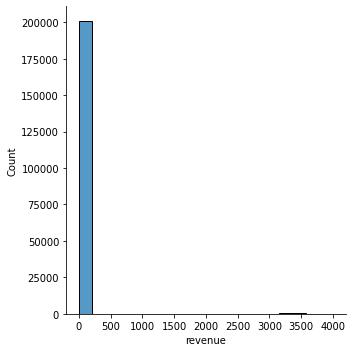

In [86]:
# строим графики распределений дохода в контрольной и тестовой группе

sns.displot (df_control_u_rev)
sns.displot (df_test_u_rev)

Как видно из графиков, распределения отклоняются от нормальной формы из-за сильного положительного перекоса и существуют большие выбросы. Это вызвано преобладанием неплатящих пользователей в обеих группах (около 99%). Мы можем более точно высчитать процент неплатящих пользователей в наших группах. 

Для этого вычтем из 100% всех пользователей показатели конверсии в каждой из групп.

In [87]:
# процент неплатящих пользователей в контрольной и тестовой группах

round (100 - conv_control, 1), round (100 - conv_test, 1)

(99.0, 99.1)

Посмотрим сколько это будет в абсолютных значениях.

In [88]:
# количество неплатящих пользователей в контрольной и тестовой группах

df_control_u_rev.loc [df_control_u_rev == 0]. count (), df_test_u_rev.loc [df_test_u_rev == 0]. count ()

(200175, 200862)

Разобравшись с характером распределений, перейдем к проверке равенства их дисперсий с помощью теста Левена.

In [89]:
# реализуем тест Левена

scipy.stats.levene (df_control_u_rev, df_test_u_rev, center = 'median') 

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Тест Левена показал p-значение значительно выше критического уровня значимости 0.05, что не позволяет нам отклонить нулевую гипотезу об отстутствии сильных различий в дисперсиях распределений.

Давайте более пристально посмотрим на различия стандартных отклонений наших распределений. Мы будем смотреть стандартные отклонения, а не дисперсию, поскольку дисперсия - это не что иное как квадрат стандартного отклонения, поэтому стандартные отклонения нагляднее показывают реальную меру изменчивости.

In [90]:
# рассчитываем стандартные отклонения обоих распределений

df_control_u_rev.std (), df_test_u_rev.std ()

(920.7681368333677, 287.32416166927845)

In [91]:
# рассчитываем кратную разницу стандартных отклонений обоих распределений с оруглением до десятых

round (df_control_u_rev.std () / df_test_u_rev.std (), 1)

3.2

Как видно, стандартные отклонения отличаются в три с лишним раза и эта разница не позволяет преодолеть альфа-уровень в тесте Левена.


Несмотря на то, что доход в контрольной и тестовой группах распределены ненормально, дисперсии у групп сильно не отличаются и группы сопоставимы по размеру, поэтому мы все равно можем попробовать использовать двухвыборочный t-критерий Стьюдента (t-тест). Он проверяет стат.значимость различий выборочных средних двух групп, а это как раз то, что нам нужно для обоснованного вывода о стат.значимости изменений ARPU.

In [92]:
# реализуем t-тест

scipy.stats.ttest_ind (df_control_u_rev, df_test_u_rev)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

Тест Стьюдента показал p-значение выше критического уровня значимости 0.05, что не позволяет нам отклонить нулевую гипотезу об отсутствии стат.значимости различий выборочных средних наших групп.

Так как у нас распределения с сильной дисперсией и выбросами и поскольку t-тест не устойчив к выбросам, мы можем прологарифмировать распределения для повышения чувствительности t-теста. В силу своих математических свойств логарифмирование позволит "прижать" выбросы к основному массиву данных. 

Однако в наших распределениях есть нули, поэтому для начала нам следует избавиться от них прибавлением единицы к данным, поскольку логарифм от нуля не определен.

In [93]:
# прибавляем единицу ко всем наблюдениям в обеих группах и записываем результаты в новые датафремы

df_control_u_rev_adj = df_control_u_rev + 1
df_test_u_rev_adj = df_test_u_rev + 1

In [94]:
# логарифмируем распределения и записываем результаты в новые датафремы

df_control_u_rev_log = np.log (df_control_u_rev_adj)
df_test_u_rev_log = np.log (df_test_u_rev_adj)

Давайте теперь оценим насколько нам удалось сократить дисперсию наших данных с помощью логарифмирования

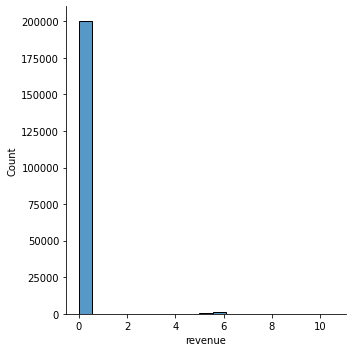

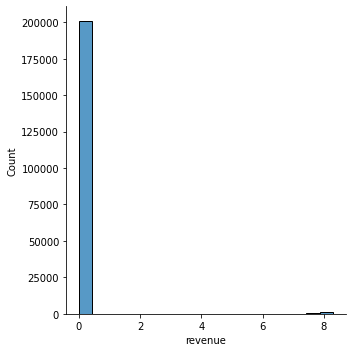

In [95]:
# строим графики

sns.displot (df_control_u_rev_log)
sns.displot (df_test_u_rev_log)

In [96]:
# рассчитываем стандартные отклонения

df_control_u_rev_log.std (), df_test_u_rev_log.std ()

(0.5952334744967485, 0.7508138449915979)

Нам действительно удалось сократить дисперсию обоих распределений и сделать выбросы менее радикальными. 

Теперь реализуем тест Стьюдента на логарифмированных данных.

In [97]:
scipy.stats.ttest_ind (df_control_u_rev_log, df_test_u_rev_log)

Ttest_indResult(statistic=-6.5121724164204435, pvalue=7.415779073120386e-11)

Тест Стьюдента на логарифмированных данных показал стат.значимость различий в средних. Мы доверяем больше этому результату, так как t-тест часто ошибается при наличии сильных выбросов.

Итак, мы подтвердили стат.значимость различий в ARPU в контрольной и тестовой группах, теперь посчитаем их размер. Так как ARPU - это средний доход с пользователя, проще всего его посчитать усреднением дохода по всем пользователям, что мы и сделаем.

In [98]:
# считаем ARPU в контрольной группе с округлением до сотых

ARPU_control = round (df_control_u_rev. mean (), 2)
ARPU_control

25.41

In [99]:
# считаем ARPU в тестовой группе с округлением до сотых

ARPU_test = round (df_test_u_rev. mean (), 2)
ARPU_test

26.75

In [100]:
# считаем прирост ARPU в процентах в тестовой группе с округлением до десятых

round ((ARPU_test - ARPU_control) / (ARPU_control / 100), 1)

5.3

Из условий задачи нам известно, что ARPU вырос на 5% и мы действительно получили в ходе наших расчетов подобное значение прироста.

Перейдем теперь к анализу статистической значимости и размера эффекта изменения нашей последней ключевой метрики - ARPPU или среднего дохода с платящего пользователя.

In [101]:
# создаем датафреймы с доходом с платящих пользоваталей в тестовой и контрольной группах

df_test_pu = df_1.query ('testgroup == "test" & revenue !=0')
df_control_pu = df_1.query ('testgroup == "control" & revenue !=0')

In [102]:
# проверяем размеры этих групп

df_control_pu.shape [0], df_test_pu.shape [0]

(1928, 1805)

In [103]:
# создаем для удобства расчётов датафреймы с доходами тестовой и контрольной групп

df_test_pu_rev = df_test_pu.revenue
df_control_pu_rev= df_control_pu.revenue

Далее действуем по той же схеме, что и в случае анализа ARPU.

In [104]:
# реализуем проверку распределений на нормальность

[scipy.stats.normaltest (df_control_pu_rev), scipy.stats.normaltest (df_test_pu_rev)] 

[NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303),
 NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)]

Тест на нормальность рассчитал для обоих распределений p-значение сильно ниже критического уровня значимости 0.05, что позволяет нам отклонить нулевую гипотезу о нормальности распределений и принять альтернативную гипотезу о ненормальном характере распределений.

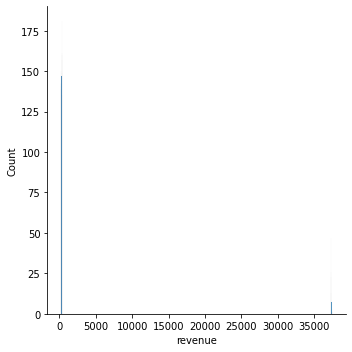

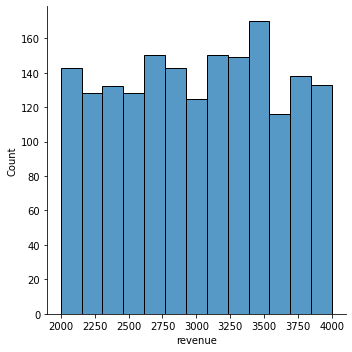

In [105]:
# строим графики распределений групп

sns.displot (df_control_pu_rev)
sns.displot (df_test_pu_rev)

Как видно из графиков, наши группы сильно отличаются по  форме распределений. В контрольной группе огромный размах в сумме покупки и бОльшая часть клиентов совершала покупки на небольшие суммы. В тестовой группе доход с клиентов распределен более компактно и в среднем клиенты чаще совершали покупки на бОльшие суммы, чем в контрольной группе. 

Исходя из графиков, мы можем предположить огромную разницу в мерах вариативности между двумя группами.

In [106]:
# реализуем тест Левена

scipy.stats.levene (df_control_pu_rev, df_test_pu_rev, center = 'median') 

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Тест Левена показал p-значение сильно ниже критического уровня значимости 0.05, что позволяет нам отклонить нулевую гипотезу и принять альтернативную гипотезу о наличии стат.значимых различий в дисперсиях.

In [107]:
# рассчитываем стандартные отклонения обоих распределений

df_control_pu_rev.std (), df_test_pu_rev.std ()

(9049.039763414252, 572.6197093504265)

In [108]:
# рассчитываем кратную разницу стандартных отклонений обоих распределений с округлением до десятых

round (df_control_pu_rev.std () / df_test_pu_rev.std (), 1)

15.8

Как видно, стандартные отклонения отличаются почти в 16 раз, и эта огроммная разница однозначно позволяет преодолеть альфа-уровень в тесте Левена.

Несмотря на то, что доход в контрольной и тестовой группах распределены ненормально и дисперсии у групп сильно отличаются, группы сопоставимы по размеру, поэтому мы все равно можем попробовать использовать t-тест, но с поправкой Уэлча на неравные дисперсии.

In [109]:
# рассчитываем t-test c поправкой Уэлча

scipy.stats.ttest_ind (df_control_pu_rev, df_test_pu_rev, equal_var = False)

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

Как мы видим, поправка Уэлча на неравенство дисперсий все равно не позволила преодолеть альфа-уровень значимости и отклонить нулевую гипотезу.

Как мы видели из графиков, в контрольной группе присутствуют большие выбросы, поэтому попробуем снова прологарифмировать наши распределения.

Так как в наших распределениях нет нулей (все юзеры - платящие), то единицу прибавлять не надо.

In [111]:
# логарифмируем распределения и записываем результаты в новые датафремы

df_control_pu_rev_log = np.log (df_control_pu_rev)
df_test_pu_rev_log = np.log (df_test_pu_rev)

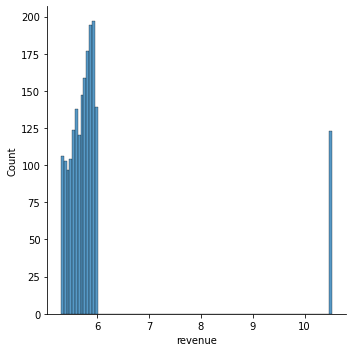

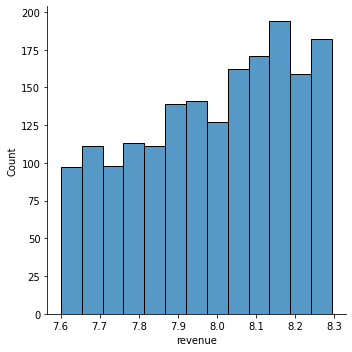

In [112]:
# строим графики

sns.displot (df_control_pu_rev_log)
sns.displot (df_test_pu_rev_log)

In [113]:
# рассчитываем стандартные отклонения

df_control_pu_rev_log.std (), df_test_pu_rev_log.std ()

(1.1972568747781691, 0.19664519799942098)

Нам вновь удалось сократить дисперсию обоих распределений и сделать выбросы менее радикальными.

Теперь реализуем тест Стьюдента на логарифмированных данных.

In [82]:
scipy.stats.ttest_ind (df_control_pu_rev_log, df_test_pu_rev_log)

Ttest_indResult(statistic=-69.65186591961508, pvalue=0.0)

Тест Стьюдента на логарифмированных данных показал стат.значимость различий в средних. Мы снова доверяем больше этому результату, так как t-тест часто ошибается при наличии сильных выбросов.

Итак, мы подтвердили стат.значимость различий в ARPPU в контрольной и тестовой группах, теперь посчитаем их размер. Так как ARPPU - это средний доход c платящего пользователя, проще всего его посчитать усреднением прибыли со всех платящих пользователей, что мы и сделаем.

In [114]:
# считаем ARPPU в контрольной группе с округлением до сотых

ARPPU_control = round (df_control_pu_rev. mean (), 2) 
ARPPU_control

2664.0

In [115]:
# считаем ARPPU в тестовой группе с округлением до сотых

ARPPU_test = round (df_test_pu.revenue. mean (), 2)
ARPPU_test

3003.66

In [116]:
# считаем прирост ARPPU в процентах в тестовой группе с округлением до дестяых

round ((ARPPU_test - ARPPU_control) / (ARPPU_control / 100), 1)

12.7

Мы могли бы посчитать ARPPU по-другому, умножив коэффициент повторных покупок на средний чек. Давайте ради интереса проверим, есть ли в наших контрольных и тестовых группах повторные покупки. Выясним это посредством проверки того, совпадает ли количество уникальных айди с количеством всех айди, то есть проверим, не повторяются ли айди несколько раз в наших группах.

In [117]:
# проверяем для обеих групп

df_control_pu.user_id.nunique () == df_control_pu.user_id.count (), \
df_test_pu.user_id.nunique () == df_test_pu.user_id.count ()

(True, True)

Таким образом, мы выяснили, что в наших группах повторных покупок нет, поскольку количество уникальных айди совпадает с их общим количеством.

**Вывод:** Итак, мы сравнили три ключевые метрики - конверсию, ARPU и ARPPU. Конверсия стат.значимо, но незначительно упала в тестовой группе. Однако малое падение конверсии (-0.06%) с лихвой перекрывается немалым стат.значимым ростом и ARPPU (+12,7%) и ARPU (+5,3%) в тестовой группе.

Таким образом, мы рекомендуем раскатывать тестовый набор акционных предложений на всех пользователей.

-----------
**Задание 3**

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

1. Начнем с первого события. Игровые события - это сложные явления, которые можно анализировать с разных сторон. Мы будем оценивать результаты прошедшего события с помощью следующих метрик:

    - *DAU и WAU*: метрика, показывающая количество активных игроков в день/неделю. Мы предполагаем, что в неделю и дни, когда проходит событие количество активных игроков повысится, особенно если мы настроили пуш-уведомления о событии игрокам. Мы можем сравнить эти метрики с аналогичными показателями событий предыдущих месяцов. Это поможет нам косвенно выяснить насколько интересным было игровое событие этого месяца;  
    - *Уровень участия*: метрика, показывающая, сколько игроков приняло участие в событии. Она показывает привлекательность игрового события для игроков и может быть измерена в процентах от общего числа DAU или в абсолютном числе игроков. Мы можем сравнить эту метрику с показателями прошлых месяцов. Это поможет нам напрямую выяснить, насколько интересным было игровое событие этого месяца; 
    - *Конверсия в получение награды*: метрика, отражающая сколько игроков достигли целей события и получили награды. Она вычисляется как отношение числа игроков, получивших награды к общему числу игроков, принявших участие в событии. Мы можем сравнить эту метрику с показателями прошлых месяцев. Это поможет нам выяснить, насколько привлекательными были награды в этом месяце, а так же косвенно выяснить, насколько сложным было событие с точки зрения игровых механик (если уровни были сложными и времени на их прохождение давалось мало, то можно предположить, что игроков, дошедших до конца будет меньше); 
    - *Average Session Duration*: метрика, показывающая среднюю длительность игровых сессий. Она вычисляется как отношение суммарной продолжительность сессий за определенный период к общему количество сессий за тот же период. Мы предполагаем, что ASD во время игрового события увеличится, так как игроки будут проводить больше времени в приложении, пытаясь его пройти. Эта метрика отражает вовлеченность игроков в игровое событие. Можно сравнить метрику с аналогичными показателями за прошлые месяцы, чтобы выяснить насколько интересным является последнее событие для игроков;
    - *ARPPU*: метрика, показывающая средний доход с платящего пользователя. Мы предполагаем, что во время игрового события она повысится, так как во время его прохождения ряд игроков скорее всего будет покупать бонусы для более легкого и быстрого прохождения уровней. Мы можем сравнить ее с показателями прошлых месяцев, чтобы выяснить, насколько привлекательными были награды последнего игрового события для игроков;
    - *Churn rate*: метрика, показывающая отток пользователей из нашей игры. Мы рассчитаем ее отткалкиваясь от числа пользователей на начало события (С1), числа новых пользователей за период (С2) и числа пользователей на конец события (С3): (С1+С2)-С3/С1*100%. Если эта метрика вырастет по отношению к событиям прошлых месяцев, это может означать, что пользователям надоела существующая механика игровых событий и нам нужно менять их механику либо награды не достаточно ценны, чтобы мотивировать игроков принять участие в событии и нам нужно повысить их ценность.

2. Во втором событии мы усложнили игровую механику события, добавив откат на несколько уровней назад при неудачном прохождении уровня. Наши метрики остались теми же, но изменились наши ожидания относительно них:

    - *DAU/WAU и Уровень участия*: если мы смогли донести до игроков ценность нового игрового события, то эти метрики скорее всего повысятся по отношению к первому событию, так как новизна и челленедж привлекают людей;
    - *Конверсия в получение награды*: эта метрика скорее всего просядет, так как игровая механика усложнилась. Если она просядет значительно, это значит, что новая игровая механика слишком сложна для игроков или награда не представляет для них особой ценности. Если же метрика просядет незначительно, это значит, что игроки в целом справляются с новой игровой механикой или они замотивированы игровой наградой и наше событие прошло успешно;
    - *Average Session Duration*: эта метрика скорее всего увеличится, так как игрокам придется перепроходить уровни, возможно, и не по одному разу. Если эта метрика вырастет умеренно, то это укладывается в наши ожидания от усложнения игровой механики. Однако если она вырастет слишком сильно, то это может служить индикатором, что новая механика слишком сложна для большинства наших игроков и нам следует упростить её;
    - *ARPPU*: эта метрика скорее всего вырастет, поскольку игроки будут тратить больше бонусов, чтобы справиться с усложненной игровой механикой. Если эта метрика вырастет значительно, это значит, что игровое событие интересно для наших пользователей и награда ценна и они готовы инвестировать свои средства в его прохождение и получение награды;
    - *Churn rate*: эта метрика скорее всего немного вырастет из-за усложнения игровой механики события. Если она вырастет значительно, это может означать, что новая механика слишком сложна для значительной части наших игроков и нам нужно снизить её сложность или повысить ценность награды.
    
    


Спасибо за внимание! :)